<a href="https://colab.research.google.com/github/MichelleAppel/Importance_sampling/blob/master/experiments_multilabel/Toy_example_estimation_of_Radon-Nikodym_derivative_MNIST_multilabel_one_sided_f_tries_std.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toy example estimation of Radon-Nikodym derivative for MNIST dataset (one sided) with **variance/std loss**

What's in this notebook (most notable things):
* implementation of the variance/std loss according to equation (2) of [the paper](https://www.overleaf.com/6488489529qjxjvhhhvhcg). 
* labels are still numbers (not one-hot encoded vectors)
* currently the f function is a randomly initialized and untrained (frozen) neural network

Possible improvements:
* check the implementation of mean/std loss
* tune hyperparameters
* one-hot encoding for labels

Similar to [Toy_example_estimation_of_Radon-Nikodym_derivative_MNIST_multilabel_one_sided_f_tries](https://colab.research.google.com/drive/1hDXIHdSIE3692OJuDYHH1qpmuNUzvXLJ#scrollTo=AhUCgoDafzHC), but the loss now implements a variance-std loss.

### Initializations

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import torchvision
import numpy as np
import math

import itertools

import matplotlib.pyplot as plt

In [2]:
def visualize_img_batch(batch):
    '''Visualizes image batch
    
    Parameters:
    batch (Tensor): An image batch
    '''
    
    print("*** batch ***")
    print('Batch dim:' + str(batch.shape[0]))
    print('0 :' + str((batch==0.0).sum().item()))
    print('1 :' + str((batch==1.0).sum().item()))
    print('2 :' + str((batch==2.0).sum().item()))
    print('3 :' + str((batch==3.0).sum().item()))
    print('4 :' + str((batch==4.0).sum().item()))
    print('5 :' + str((batch==5.0).sum().item()))
    print('6 :' + str((batch==6.0).sum().item()))
    print('7 :' + str((batch==7.0).sum().item()))
    print('8 :' + str((batch==8.0).sum().item()))
    print('9 :' + str((batch==9.0).sum().item()))

    batch_formatted = torch.tensor(batch[:64]).unsqueeze(1).cuda() 
    for i in range(8):
      #print('{} {} {} {} {} {} {} {} {} {}'.format(batch[]))
      string = ''
      for j in range(8):
        string = string + ' {}'.format(int(batch_formatted[i*8+j][0]))
      print(string)
      
def visualize_MNIST_img_batch(batch):
    '''Visualizes image batch for MNIST
    
    Parameters:
    batch (Tensor): An image batch
    '''
    fig = plt.figure()
    for i in range(batch.shape[0]):
      plt.subplot(1,batch.shape[0],i+1)
      plt.tight_layout()
      plt.imshow(batch[i], cmap='gray', interpolation='none')
      plt.title("Ground Truth: {}".format(i))
      plt.xticks([])
      plt.yticks([])

In [3]:
def MNIST_data(distribution=[0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], dim_res = 60000, one_hot_labels = False):
    # distribution: distribution for each label
    # returns (data, labels) for MNIST with all the classes; zeroes and ones have the given distribution

    MNIST = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
    print(MNIST.train_labels.size()) # original size: 60 000 (around 6000 samples/class)
    
    distribution /= np.array(distribution).sum()
    
    # bool mask for each label
    idxm = [MNIST.train_labels==label for label in range(10)]
    #print(idxm)

    # list of indices for each label
    idx = [np.where(idxm[label])[0] for label in range(10)]
    for label in range(10):
      wanted_len = dim_res * distribution[label]
      ratio = wanted_len / len(idx[label])
      
      if len(idx[label]) < int(dim_res * distribution[label]):
        for i in range(math.floor(ratio)-1):
          idx[label] = np.concatenate((idx[label], idx[label]))
        if ratio - math.floor(ratio) > 0 :
          remaining_el = math.floor((ratio - math.floor(ratio)) * len(idx[label]))
          idx[label] = np.concatenate((idx[label], idx[label][0:remaining_el]))
      else:
        remaining_el = math.floor(ratio * len(idx[label]))
        idx[label] = idx[label][0:remaining_el]

    # list of valid indices (i.e. indices for the result) for each label
    valid_idx = []
    for label in range(10):
      valid_idx = valid_idx + idx[label].tolist()
    # sort
    valid_idx = np.array(valid_idx)
    np.random.shuffle(valid_idx)

    # assign the new data and labels to the dataset
    if one_hot_labels:
      MNIST.targets =  torch.nn.functional.one_hot( MNIST.train_labels[valid_idx])
    else:
      MNIST.targets = MNIST.train_labels[valid_idx]
    MNIST.data = MNIST.train_data[valid_idx]

    return MNIST 


# TEST
distribution =  [5, 5, 5, 5, 5, 0.5, 0.5, 0.5, 0.5, 0.5] #[0.15, 0.15, 0.15, 0.15, 0.15, 0.5, 0.5, 0.5, 0.5, 0.5]
res = MNIST_data( [5, 5, 5, 5, 5, 0.5, 0.5, 0.5, 0.5, 0.5], one_hot_labels = False)
#print(res)
#print(res.targets.tolist()) #labels
#print(res.data) #data
'''
print(res)
print('0 =' + str((res.train_labels==0).sum().item()))
print('1 =' + str((res.train_labels==1).sum().item()))
print('2 =' + str((res.train_labels==2).sum().item()))
print('3 =' + str((res.train_labels==3).sum().item()))
print('4 =' + str((res.train_labels==4).sum().item()))
print('5 =' + str((res.train_labels==5).sum().item()))
print('6 =' + str((res.train_labels==6).sum().item()))
print('7 =' + str((res.train_labels==7).sum().item()))
print('8 =' + str((res.train_labels==8).sum().item()))
print('9 =' + str((res.train_labels==9).sum().item()))'''

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!
torch.Size([60000])


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


"\nprint(res)\nprint('0 =' + str((res.train_labels==0).sum().item()))\nprint('1 =' + str((res.train_labels==1).sum().item()))\nprint('2 =' + str((res.train_labels==2).sum().item()))\nprint('3 =' + str((res.train_labels==3).sum().item()))\nprint('4 =' + str((res.train_labels==4).sum().item()))\nprint('5 =' + str((res.train_labels==5).sum().item()))\nprint('6 =' + str((res.train_labels==6).sum().item()))\nprint('7 =' + str((res.train_labels==7).sum().item()))\nprint('8 =' + str((res.train_labels==8).sum().item()))\nprint('9 =' + str((res.train_labels==9).sum().item()))"

In [4]:
class MNISTDataset(Dataset):
    '''The dataset for the MNIST binary data
    '''
    def __init__(self, distribution = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], dim_res = 60000, one_hot_labels = False):

        self.ratio = distribution
        self.dim_res = dim_res
        
        self.dataset = MNIST_data(distribution=self.ratio, dim_res = self.dim_res, one_hot_labels = one_hot_labels)
        
        self.example_imgs = self.example()
        
        # to take out in real applications
        self.unique_labels = torch.unique(self.dataset.targets)

    def example(self):
        '''
        Returns an example from each digit in the domain
        
        '''
        labels = self.dataset.targets
        data = self.dataset.data
        '''img0 = data[labels==0][0].unsqueeze(0)
        img1 = data[labels==1][0].unsqueeze(0)
        img2 = data[labels==2][0].unsqueeze(0)
        img3 = data[labels==3][0].unsqueeze(0)
        img4 = data[labels==4][0].unsqueeze(0)
        img5 = data[labels==5][0].unsqueeze(0)
        img6 = data[labels==6][0].unsqueeze(0)
        img7 = data[labels==7][0].unsqueeze(0)
        img8 = data[labels==8][0].unsqueeze(0)
        img9 = data[labels==9][0].unsqueeze(0)
        ex = torch.cat((img0, img1, img2, img3, img4, img5, img6, img7, img8, img9), 0)'''
        img = []
        for label in torch.unique(labels):
          img = img + [data[labels==label][0].unsqueeze(0)]
        ex = torch.cat(img, 0)
              
        return ex

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

# TEST
'''
dataset = MNISTDataset()

fig = plt.figure()
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.tight_layout()
  plt.imshow(dataset.example_imgs[i].cpu(), cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(i))
  plt.xticks([])
  plt.yticks([])'''

'\ndataset = MNISTDataset()\n\nfig = plt.figure()\nfor i in range(10):\n  plt.subplot(1,10,i+1)\n  plt.tight_layout()\n  plt.imshow(dataset.example_imgs[i].cpu(), cmap=\'gray\', interpolation=\'none\')\n  plt.title("Ground Truth: {}".format(i))\n  plt.xticks([])\n  plt.yticks([])'

torch.Size([60000])


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000])




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations



*** Dataset A ***
33147
0 =18153
1 =1666
2 =1666
3 =1666
4 =1666
5 =1666
6 =1666
7 =1666
8 =1666
9 =1666

*** Dataset B ***
29999
0 =3000
1 =3000
2 =3000
3 =3000
4 =3000
5 =3000
6 =2999
7 =3000
8 =3000
9 =3000


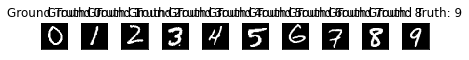

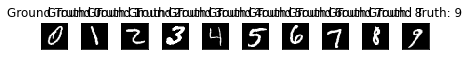

In [5]:
# Settings for domain A (red)
one_hot_labels = False

ratio_A = [0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] #[0.05, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
ratio_A /= np.array(ratio_A).sum()
dataset_A = MNISTDataset(distribution=ratio_A, dim_res = 30000, one_hot_labels = one_hot_labels)
dataloader_A = DataLoader(dataset_A, batch_size=128, shuffle=True) #64, shuffle=True)

# Settings for domain B (green)
ratio_B = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
ratio_B /= np.array(ratio_B).sum()
dataset_B = MNISTDataset(distribution=ratio_B, dim_res = 30000, one_hot_labels = one_hot_labels)
dataloader_B = DataLoader(dataset_B, batch_size=128, shuffle=True) #64, shuffle=True)


visualize_MNIST_img_batch(dataset_A.example_imgs.cpu())
visualize_MNIST_img_batch(dataset_B.example_imgs.cpu())

print('\n*** Dataset A ***')
print(len(dataset_A))
print('0 =' + str((dataset_A.dataset.train_labels==0).sum().item()))
print('1 =' + str((dataset_A.dataset.train_labels==1).sum().item()))
print('2 =' + str((dataset_A.dataset.train_labels==2).sum().item()))
print('3 =' + str((dataset_A.dataset.train_labels==3).sum().item()))
print('4 =' + str((dataset_A.dataset.train_labels==4).sum().item()))
print('5 =' + str((dataset_A.dataset.train_labels==5).sum().item()))
print('6 =' + str((dataset_A.dataset.train_labels==6).sum().item()))
print('7 =' + str((dataset_A.dataset.train_labels==7).sum().item()))
print('8 =' + str((dataset_A.dataset.train_labels==8).sum().item()))
print('9 =' + str((dataset_A.dataset.train_labels==9).sum().item()))
print('\n*** Dataset B ***')
print(len(dataset_B))
print('0 =' + str((dataset_B.dataset.train_labels==0).sum().item()))
print('1 =' + str((dataset_B.dataset.train_labels==1).sum().item()))
print('2 =' + str((dataset_B.dataset.train_labels==2).sum().item()))
print('3 =' + str((dataset_B.dataset.train_labels==3).sum().item()))
print('4 =' + str((dataset_B.dataset.train_labels==4).sum().item()))
print('5 =' + str((dataset_B.dataset.train_labels==5).sum().item()))
print('6 =' + str((dataset_B.dataset.train_labels==6).sum().item()))
print('7 =' + str((dataset_B.dataset.train_labels==7).sum().item()))
print('8 =' + str((dataset_B.dataset.train_labels==8).sum().item()))
print('9 =' + str((dataset_B.dataset.train_labels==9).sum().item()))

*** Batches distribution ***

*** Batch from domain A ***
*** batch ***
Batch dim:128
0 :77
1 :3
2 :7
3 :10
4 :4
5 :4
6 :8
7 :9
8 :4
9 :2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


 0 0 0 2 0 0 6 0
 3 0 2 0 0 4 0 5
 0 7 3 8 0 0 0 2
 0 5 0 0 8 0 0 0
 0 0 4 0 8 0 4 0
 0 0 2 1 0 7 0 0
 0 0 0 7 0 7 0 0
 0 3 6 1 0 0 2 5


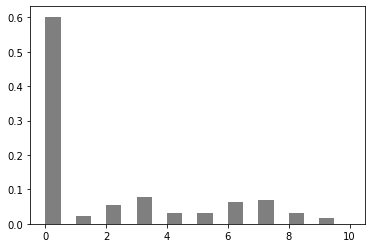


*** Batch from domain B ***
*** batch ***
Batch dim:128
0 :15
1 :16
2 :10
3 :12
4 :10
5 :20
6 :16
7 :12
8 :6
9 :11
 7 3 6 8 0 3 4 5
 5 6 9 5 0 6 5 6
 4 9 2 9 0 1 6 5
 5 5 1 6 9 9 2 5
 5 4 7 4 5 2 0 5
 7 1 6 3 5 9 5 1
 5 2 7 3 8 2 9 0
 6 1 7 6 9 8 1 7


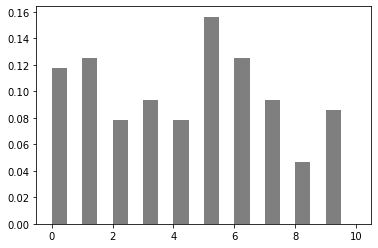

In [6]:
import cv2

def plot_hist(data):
    data = data.squeeze().cpu()
   
    legend = []
    for label in range(10):
      plt.hist(data[data==label], weights=torch.ones(len(data[data==label]))/len(data), 
             color='black', bins=20, range= (0, 10), alpha=0.5)
      legend = legend + ['Imgs for label {}'.format(label)]
    #plt.legend(legend)
    #plt.gca().set_facecolor('xkcd:gray')
    x_unique_count = torch.stack([(data==x_u).sum() for x_u in data.unique()])
    plt.show()

for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
    labs_A = data_A[1].double()
    labs_B = data_B[1].double()

    print('*** Batches distribution ***')
    print('\n*** Batch from domain A ***')
    visualize_img_batch(labs_A)
    plot_hist(labs_A)
    print('\n*** Batch from domain B ***')
    visualize_img_batch(labs_B)
    plot_hist(labs_B)

    break

In [7]:
class WeightNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(WeightNet, self).__init__()
        self.softmax = nn.Softmax(dim=0)

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 40)
        self.fc2 = nn.Linear(40, 1)
        
    def forward(self, x):
        x = torch.sigmoid(F.max_pool2d(self.conv1(x), 2))
        x = torch.sigmoid(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x), x

####Compute the average & variance of assigned weights, for each number, in the batches

In [8]:
# compute the average weight/importance assigned to images in the batches, and the variance

import collections

def compute_average_prob(weight_network):
    weights_total = collections.defaultdict(torch.tensor)
    weights_mean = collections.defaultdict(float)
    weights_var = collections.defaultdict(float)
    mean_weight_batch = collections.defaultdict(float)
    ratio01s = []
    unnorm_weights_batch_list = collections.defaultdict(torch.tensor)
    
    for i, (batch_A, batch_B) in enumerate(zip(dataloader_A, dataloader_B)):

        real_A = batch_A[0].cuda()
        labels_A = batch_A[1].cuda()
        weights_batch, unnorm_weights_batch = weight_network(real_A)

        possible_labels, _ = torch.unique(labels_A).sort()
        for l in possible_labels:
            indices_with_label_l = labels_A == l.item()
            if l not in weights_total.keys():
              weights_total[l.item()] = weights_batch[indices_with_label_l]
            else:
              torch.cat((weights_total[l.item()], weights_batch[indices_with_label_l]), 0)
            
            mean_weight_batch[l.item()] = weights_batch[indices_with_label_l].mean().item() # mean weight assigned to '0' and '1' for each batch: p('0',batch_i) and p('1',batch_i)

            if l not in weights_total.keys():
              unnorm_weights_batch_list[l.item()] = torch.exp(unnorm_weights_batch[indices_with_label_l])
            else:
              torch.cat((unnorm_weights_batch_list[l.item()], torch.exp(unnorm_weights_batch[indices_with_label_l])), 0) #all w_i for all i that are '0', lets call this list_0; the same for '1', lets call it list_1

        #NOTE: +1 added to numerator and denominator because mean_weight_batch[1] was 0 for some batches (when using multilabel setting)
        ratio01s += [(mean_weight_batch[0]+1) / (mean_weight_batch[1]+1)] # ratio q(batch_i) = p('0',batch_i)/p('1',batch_i)
        
    weights_tot = 0 # for normalizing weigths over digits
    for key in weights_total.keys():
        weights_mean[key] = weights_total[key].mean().item()
        weights_var[key] = weights_total[key].var().item()
        weights_tot += weights_mean[key]

    ratio01 = torch.tensor(ratio01s).mean().item() # average over all q(batch_i)

    ratio01_no_softmax = torch.tensor(unnorm_weights_batch_list[0]).mean().item() / torch.tensor(unnorm_weights_batch_list[1]).mean().item() # average over list_0, and independently over list_1, and take the quotient

    # normalize weights across digits -> this gets weigth means that sum up to 1
    for key in weights_mean.keys():
      weights_mean[key] = weights_mean[key] / weights_tot

    return weights_mean, weights_var, ratio01, ratio01_no_softmax

#compute_average_prob(weight_network)

### Different functions for f

In [9]:
class f_Net_3fcl(nn.Module):
    ''' NN with 3 fully connected layers'''

    def __init__(self):
        super(f_Net_3fcl, self).__init__()

        self.fc1 = nn.Linear(784, 392)
        self.fc2 = nn.Linear(392, 36)
        self.fc4 = nn.Linear(36, 1)

        # randomly initialize the network
        nn.init.uniform_(self.fc1.weight)
        nn.init.uniform_(self.fc2.weight)
        nn.init.uniform_(self.fc4.weight)

        # freezes the network (does not update the weights in Grad Desc.)
        for param in self.parameters():
           param.requires_grad = False
        
    def forward(self, x):
        x = x.view(-1, 784)
        fc1 = torch.sigmoid(self.fc1(x))
        fc2 = torch.sigmoid(self.fc2(fc1))
        fc3 = torch.sigmoid(self.fc4(fc2))
        fc3 = fc3.squeeze()

        # outputs a dictionary
        out = {}
        out['fc1'] = fc1 # hidden variables
        out['fc2'] = fc2 # hidden variables
        out['out'] = fc3 # output

        return out

In [10]:
class f_Net_2fcl(nn.Module):
    ''' NN with 2 fully connected layers'''

    def __init__(self):
        super(f_Net_2fcl, self).__init__()

        self.fc1 = nn.Linear(784, 36)
        self.fc4 = nn.Linear(36, 1)

        # randomly initialize the network
        nn.init.uniform_(self.fc1.weight)
        nn.init.uniform_(self.fc4.weight)

        # freezes the network (does not update the weights in Grad Desc.)
        for param in self.parameters():
           param.requires_grad = False
        
    def forward(self, x):
        x = x.view(-1, 784)
        fc1 = torch.sigmoid(self.fc1(x))
        fc2 = torch.sigmoid(self.fc4(fc1))
        fc2 = fc2.squeeze()

        # outputs a dictionary
        out = {}
        out['fc1'] = fc1 # hidden variables
        out['out'] = fc2 # output
        
        return out

In [11]:
class f_Net_1fcl(nn.Module):
    ''' NN with 1 fully connected layer'''

    def __init__(self):
        super(f_Net_1fcl, self).__init__()

        self.fc1 = nn.Linear(784, 1)

        # randomly initialize the network
        nn.init.uniform_(self.fc1.weight)

        # freezes the network (does not update the weights in Grad Desc.)
        for param in self.parameters():
           param.requires_grad = False
        
    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.sigmoid(self.fc1(x))
        x = x.squeeze()

        # outputs a dictionary
        out = {}
        out['out'] = x # output
        
        return out

In [12]:
def f_4_std(real_A, real_b, w):
   '''f = hidden values of a fixed (not-trained and randomly initialized) NN for the image'''
   
   ''' Architectures:'''
   #f=f_Net_1fcl().cuda() # 1 fcl
   #f=f_Net_2fcl().cuda() # 2 fcl
   f=f_Net_3fcl().cuda() # 3 fcl : works for f = fc1 or fc2, doesn't work for f = out

   ''' Choose which part of the NN to use as f (output or any hidden variable) by selecting the correct entry in the dictionary output of the NN '''
   f_A = f(real_A)['fc1']
   if len(list(f_A.shape)) == 1:
     weights = weight_normalization(w).view(-1)
   else:
     dim = torch.cat([torch.tensor([1]), torch.tensor(f_A.shape[1:]).long()], dim = 0)
     weights = weight_normalization(w).repeat(tuple(dim))
   c_A = (f_A.detach() * weights).mean(dim = 0)
   M = real_A.shape[2]

   f_B = f(real_B)['fc1']
   c_B = L_B = (f_B.detach()).mean(dim = 0)
   
   L_A = (f_A - c_A)**2 / M
   L_B = (f_A - c_A)**2 * weights

   return L_A, L_B

### Training

In [13]:
# Initialize the networks
weight_network = WeightNet().cuda()

# Initialize the optimizers
lr = 0.0006 #0.001
optimizer_w = optim.Adam(weight_network.parameters(), lr=lr)

losses_w = []

mean_A = []
mean_B = []

L_As = []
L_Bs = []

example_importances_A = []
example_importances_B = []

w_means = collections.defaultdict(list)
w_vars = collections.defaultdict(list)
ratio01s = []
unnorm_ratio01s = []

def weight_normalization(w):
    return w
#    return 0.5*(1 + w)

for epoch in range(12):
    for i, (batch_A, batch_B) in enumerate(zip(dataloader_A, dataloader_B)):

        real_A = batch_A[0].cuda()
        real_B = batch_B[0].cuda()
        labels_A = batch_A[1].cuda()
        labels_B = batch_B[1].cuda()

        # The weighting process
        w, unnorm_w = weight_network(real_A)
    
        # The loss function --------------------------------------------------------------------------------
        
        # Using f as objective function
        L_A, L_B = f_4_std(real_A, real_B, w)
        
        loss_w = ((L_A - L_B)**2).sum() # if f is a hidden variable, L_A and L_B are tensors, hence the sum() after the square

        mean_A += [real_A.mean()]
        mean_B += [real_B.mean()]

        # ---------------------------------------------------------------------------------------------------

        # Backward
        optimizer_w.zero_grad()
        loss_w.backward()
        optimizer_w.step()   

        # Store values --------------------------------------------------------------------------------------
        L_As += [L_A.sum().item()] # if f is a hidden variable, L_A and L_B are tensors, hence the sum()
        L_Bs += [L_B.sum().item()]
        
        losses_w += [loss_w.item()]
        
        w_a = weight_normalization((weight_network(dataset_A.example_imgs.float().unsqueeze(1).cuda())[0]))
        imps = []
        for label in dataset_A.unique_labels:
          imps = imps + [w_a[label].item()]
        example_importances_A += [imps]#[(w_a[0].item(), w_a[1].item(), w_a[2].item(), w_a[3].item(), w_a[4].item(), w_a[5].item(), w_a[6].item(), w_a[7].item(), w_a[8].item(), w_a[9].item())] # Store examples in a list
        

        if i % 20 == 0: # compute avg and var every 20 steps because it's quite slow
          mean, var, ratio01, ratio01_no_softmax_batch = compute_average_prob(weight_network)
          for key in mean.keys():
            if (key not in w_means.keys()):
              w_means[key] = []
              w_vars[key] = [] 
            w_means[key] += [mean[key]]
            w_vars[key] += [var[key]]
          ratio01s += [ratio01]
          unnorm_ratio01s += [ratio01_no_softmax_batch]

        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 20 == 0:
            print('epoch', epoch, 'step', i, 'loss_w: ', loss_w.item())
            
        if i % 5000 == 0 and i != 0:
            break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 0 step 0 loss_w:  26.805309295654297
epoch 0 step 20 loss_w:  21.882999420166016
epoch 0 step 40 loss_w:  20.65991973876953
epoch 0 step 60 loss_w:  21.25299835205078
epoch 0 step 80 loss_w:  18.00735092163086
epoch 0 step 100 loss_w:  19.31853485107422
epoch 0 step 120 loss_w:  22.13837242126465
epoch 0 step 140 loss_w:  17.51362419128418
epoch 0 step 160 loss_w:  22.5345458984375
epoch 0 step 180 loss_w:  19.845083236694336
epoch 0 step 200 loss_w:  16.527973175048828
epoch 0 step 220 loss_w:  17.883071899414062
epoch 1 step 0 loss_w:  15.12800121307373
epoch 1 step 20 loss_w:  15.97446060180664
epoch 1 step 40 loss_w:  18.500829696655273
epoch 1 step 60 loss_w:  20.77118492126465
epoch 1 step 80 loss_w:  17.939170837402344
epoch 1 step 100 loss_w:  19.360166549682617
epoch 1 step 120 loss_w:  17.86334228515625
epoch 1 step 140 loss_w:  16.263957977294922
epoch 1 step 160 loss_w:  21.517005920410156
epoch 1 step 180 loss_w:  20.314727783203125
epoch 1 step 200 loss_w:  19.80044

###Results

####Average & variance of assignedweights, for each number, in the batches

In [14]:
# compute the average weight/importance assigned to images in the batches, and the variance

mean, var, ratio01, ratio01_no_softmax_batch = compute_average_prob(weight_network)

# print stats
print("Means: ", mean)
print("Variance: ", var)
print("Ratio01: ", ratio01)
print("Not normalized ratio01: ", ratio01_no_softmax_batch)

Means:  defaultdict(<class 'float'>, {0: 0.22094440912796162, 1: 2.6512430161889026e-06, 2: 0.10960598567589772, 3: 0.05540621422764835, 4: 0.040945705826834086, 5: 0.1842337309305293, 6: 0.15894932370915377, 7: 2.784275381359136e-06, 8: 0.12465779473443675, 9: 0.10525140024914086})
Variance:  defaultdict(<class 'float'>, {0: 2.4843346182024106e-05, 1: 2.6734026776185915e-14, 2: 5.024472557124682e-05, 3: 2.7294167011859827e-05, 4: 2.6406894903630018e-05, 5: 4.1841689380817115e-05, 6: 5.6521061196690425e-05, 7: 1.3526307251186549e-14, 8: 4.326233101892285e-05, 9: 5.5755674111424014e-05})
Ratio01:  1.0101333856582642
Not normalized ratio01:  83336.1275328152


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


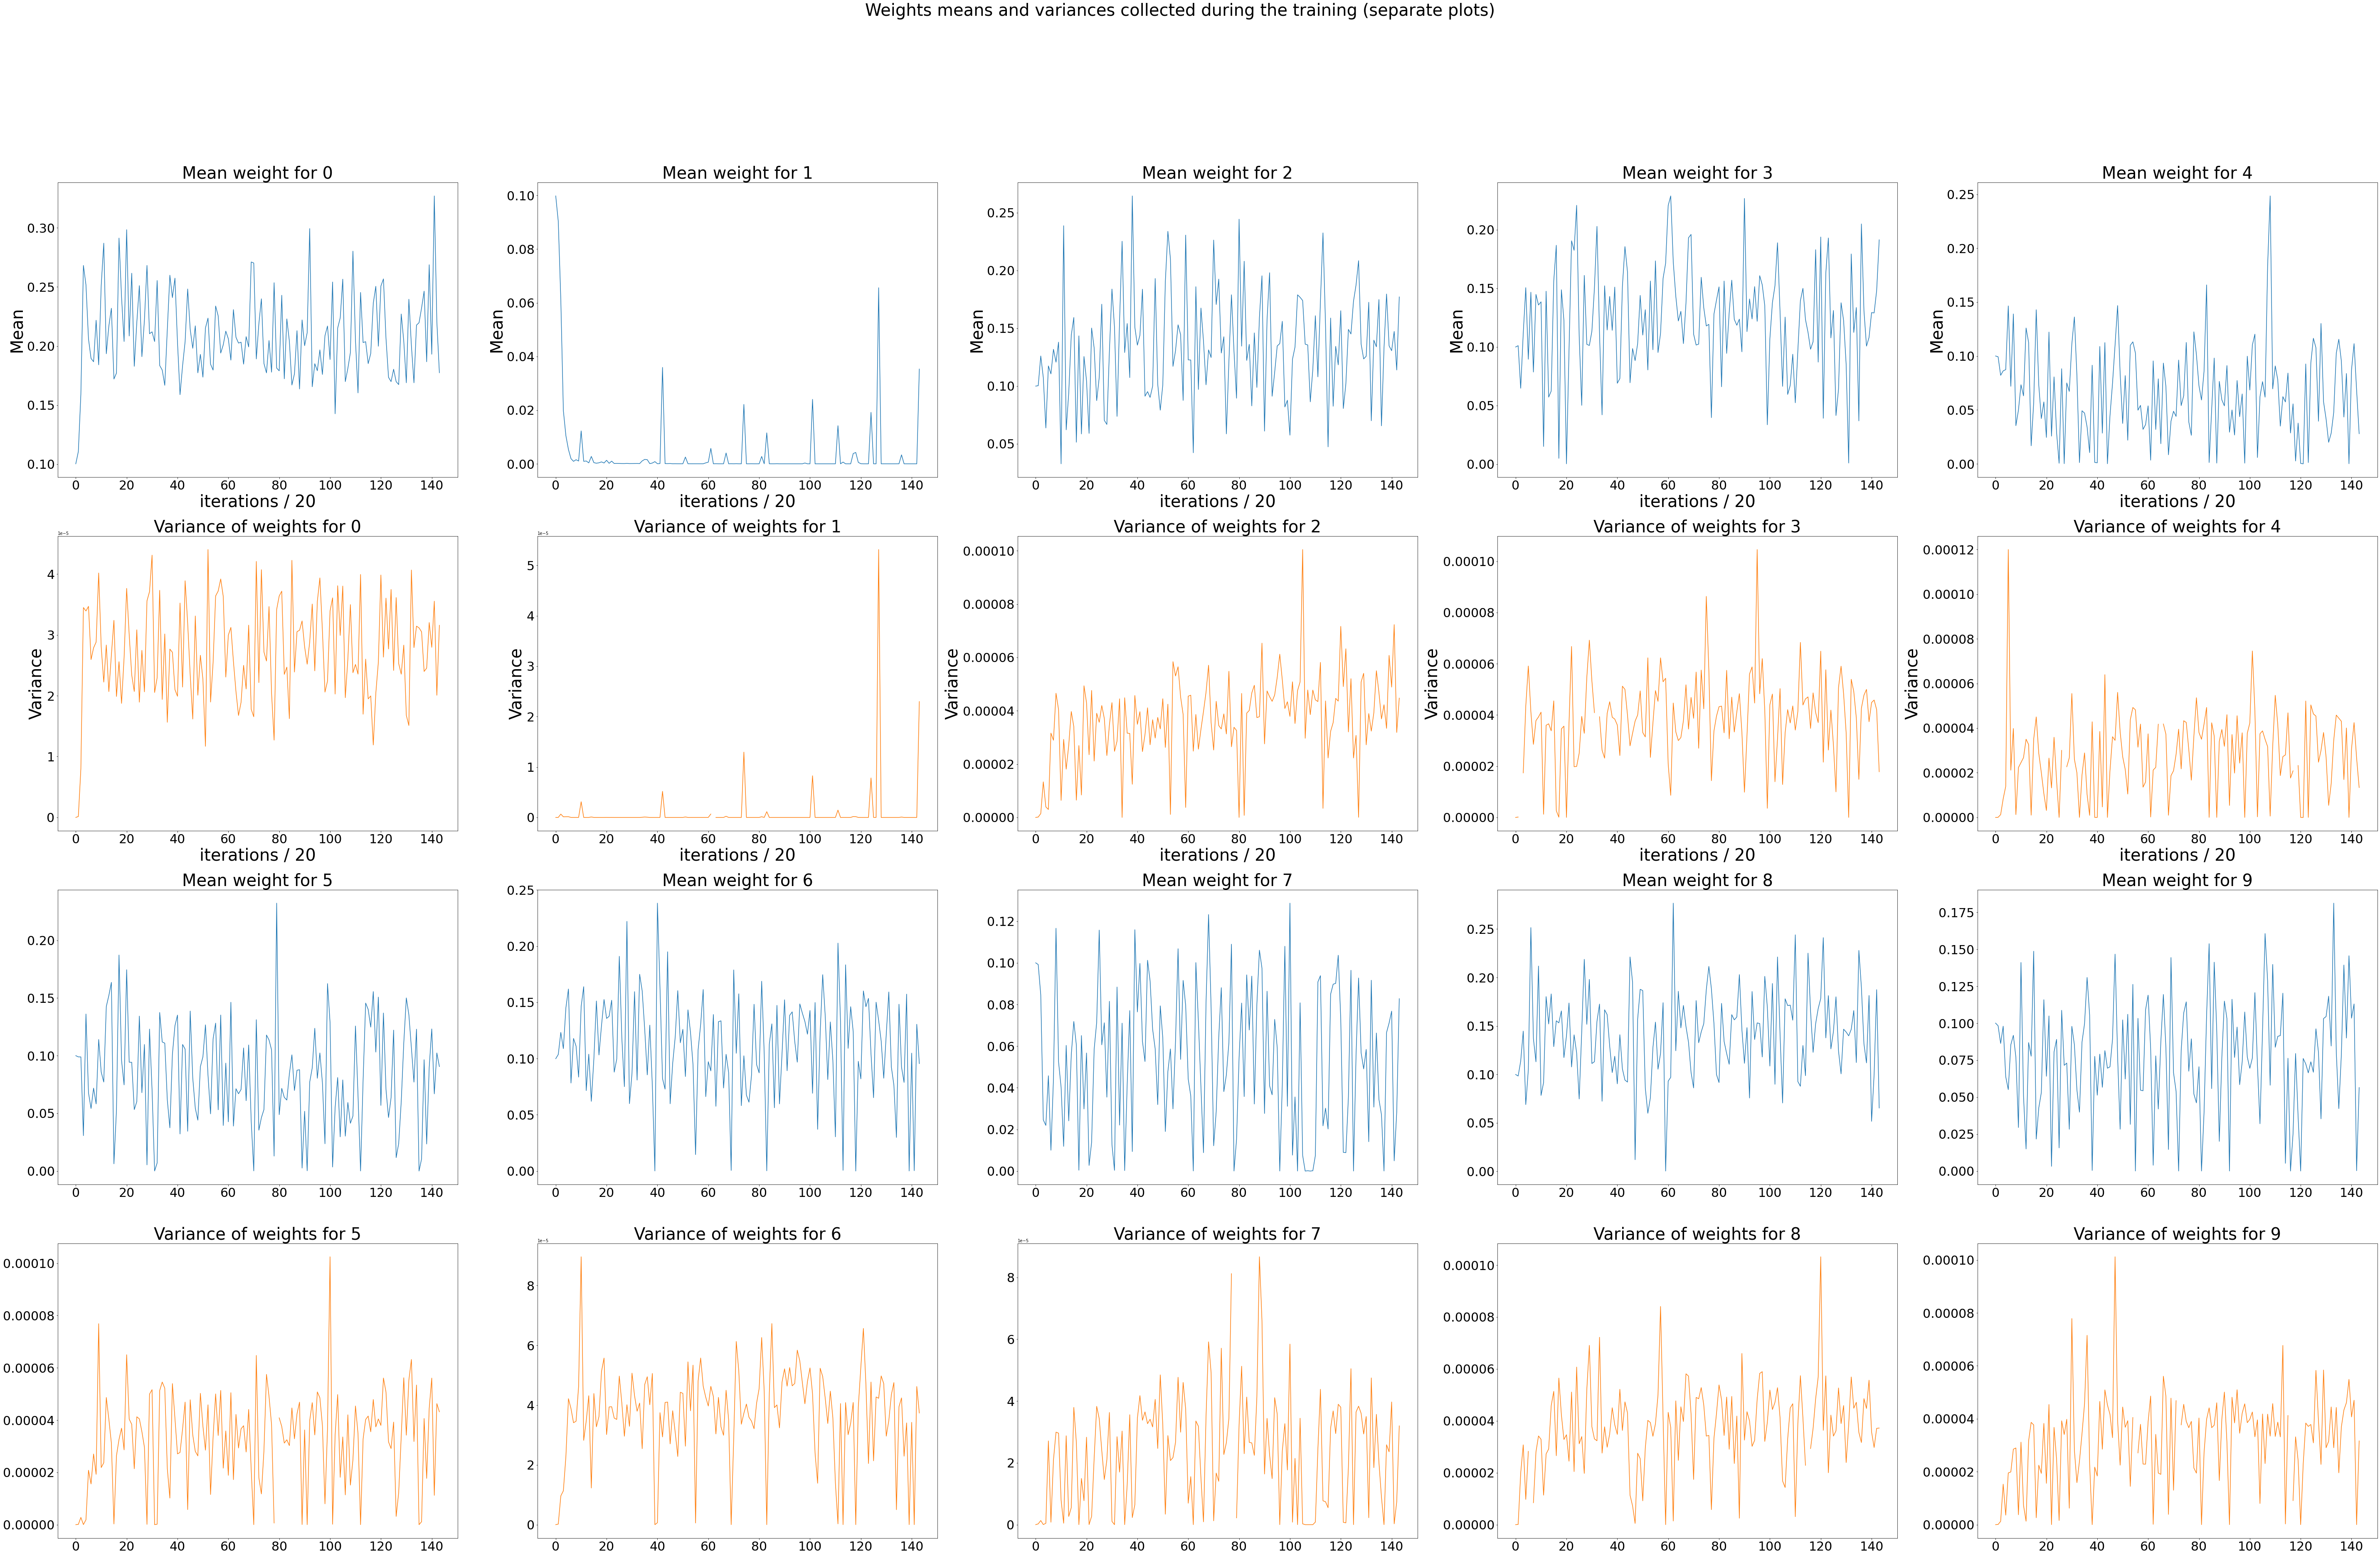

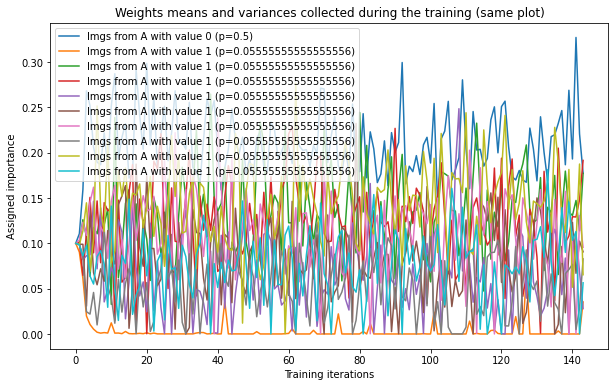

In [15]:
# plot means and variances collected during the training
fig, axs = plt.subplots(4, 5, figsize=(100,60))
fig.suptitle('Weights means and variances collected during the training (separate plots)', fontsize = 40)
for label in range(5):
  axs[0, label].plot(w_means[label])
  axs[0, label].set_title('Mean weight for {}'.format(label), fontsize = 40)
  axs[1, label].plot(w_vars[label], 'tab:orange')
  axs[1, label].set_title('Variance of weights for {}'.format(label), fontsize = 40)
for label in range(5, 10):
  axs[2, label-5].plot(w_means[label])
  axs[2, label-5].set_title('Mean weight for {}'.format(label), fontsize = 40)
  axs[3, label-5].plot(w_vars[label], 'tab:orange')
  axs[3, label-5].set_title('Variance of weights for {}'.format(label), fontsize = 40)

for ax in axs[0,:]:
  ax.set(xlabel='iterations / 20', ylabel='Mean')
for ax in axs[1,:]:
  ax.set(xlabel='iterations / 20', ylabel='Variance')

for i in range(4):
  for ax in axs[i, :]:
    ax.xaxis.label.set_size(40)
    ax.yaxis.label.set_size(40)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)


plt.figure(figsize=(10,6))
plt.title('Weights means and variances collected during the training (same plot)')
for label in range(10):
  plt.plot(w_means[label])
plt.legend(['Imgs from A with value {} (p={})'.format(0, ratio_A[0]), 
            'Imgs from A with value {} (p={})'.format(1, ratio_A[1]), 
            'Imgs from A with value {} (p={})'.format(1, ratio_A[2]), 
            'Imgs from A with value {} (p={})'.format(1, ratio_A[3]), 
            'Imgs from A with value {} (p={})'.format(1, ratio_A[4]), 
            'Imgs from A with value {} (p={})'.format(1, ratio_A[5]), 
            'Imgs from A with value {} (p={})'.format(1, ratio_A[6]), 
            'Imgs from A with value {} (p={})'.format(1, ratio_A[7]), 
            'Imgs from A with value {} (p={})'.format(1, ratio_A[8]), 
            'Imgs from A with value {} (p={})'.format(1, ratio_A[9])])
plt.ylabel('Assigned importance')
plt.xlabel('Training iterations')
plt.show()


















####Loss

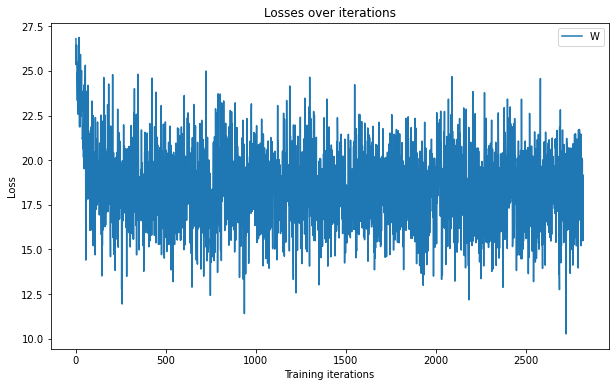

In [16]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
# plt.yscale('symlog')
plt.plot(losses_w)
plt.legend(['W'])
plt.show()

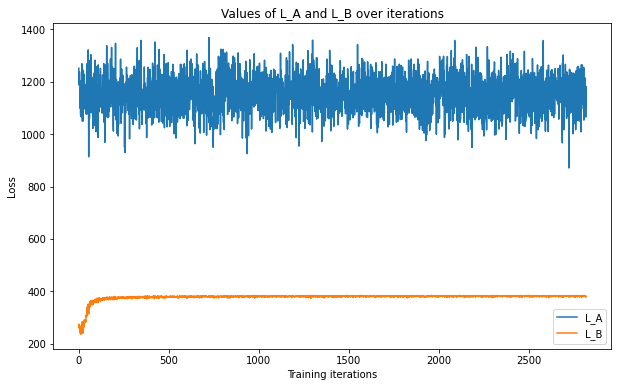

In [17]:
plt.figure(figsize=(10,6))
plt.title('Values of L_A and L_B over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(L_As)
plt.plot(L_Bs)
plt.legend(['L_A', 'L_B'])
plt.show()

####Assigned importances for the example images over the course of training

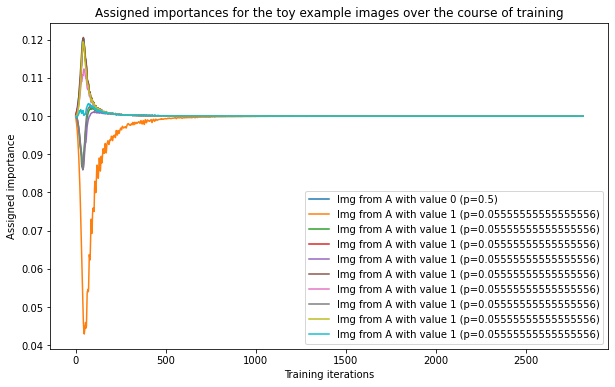

[0.10000010579824448,
 0.09999906271696091,
 0.10000010579824448,
 0.10000010579824448,
 0.10000010579824448,
 0.10000010579824448,
 0.10000010579824448,
 0.10000010579824448,
 0.10000010579824448,
 0.10000010579824448]

In [18]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the toy example images over the course of training')
plt.plot(example_importances_A)
plt.legend(['Img from A with value {} (p={})'.format(0, ratio_A[0]), 
            'Img from A with value {} (p={})'.format(1, ratio_A[1]), 
            'Img from A with value {} (p={})'.format(1, ratio_A[2]), 
            'Img from A with value {} (p={})'.format(1, ratio_A[3]), 
            'Img from A with value {} (p={})'.format(1, ratio_A[4]), 
            'Img from A with value {} (p={})'.format(1, ratio_A[5]), 
            'Img from A with value {} (p={})'.format(1, ratio_A[6]), 
            'Img from A with value {} (p={})'.format(1, ratio_A[7]), 
            'Img from A with value {} (p={})'.format(1, ratio_A[8]), 
            'Img from A with value {} (p={})'.format(1, ratio_A[9])])
plt.ylabel('Assigned importance')
plt.xlabel('Training iterations')
plt.show()

example_importances_A[-1]

####Assigned importances for the linear combination of the example images

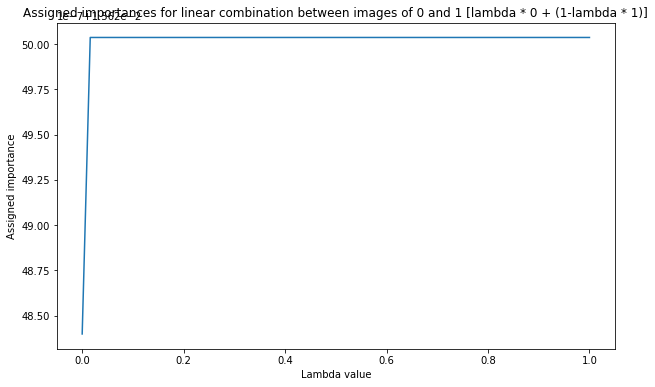

In [19]:
lambd = torch.linspace(0, 1, 64).repeat(28,28,1,1).permute(3,2,0,1)
lin_comb = lambd * dataset_A.example_imgs[0] + (1-lambd) * dataset_A.example_imgs[1]

weights, _ = weight_network(lin_comb.cuda())
weights = weights.cpu().detach().numpy()
plt.figure(figsize=(10,6))
plt.title('Assigned importances for linear combination between images of 0 and 1 [lambda * 0 + (1-lambda * 1)]')
plt.plot(torch.linspace(0, 1, 64), weights)
plt.ylabel('Assigned importance')
plt.xlabel('Lambda value')
plt.show()

Other

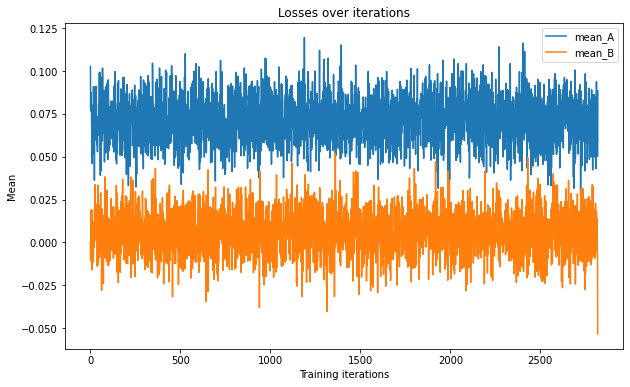

In [20]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Mean')
plt.plot(mean_A)
plt.plot(mean_B)
plt.legend(['mean_A', 'mean_B'])
plt.show()